# Step 0: Data acquisition


Importing the necessary packages

In [73]:
import pandas as pd
import numpy as np

import numpy as np
import pandas as pd

import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

Retrieving data from the 3 given csvs 

In [74]:

raw_us_cases = pd.read_csv("RAW_us_confirmed_cases.csv")
mask_use_by_county = pd.read_csv("mask-use-by-county.csv")
mask_mandates_april_2020_aug_2021 = pd.read_csv("U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")

# filtering the data for Jefferson County (KY state)
raw_jefferson_cases = raw_us_cases[(raw_us_cases["Province_State"] == "Kentucky") & (raw_us_cases["Admin2"] == "Jefferson")]


Creating a cleaner datasets for confirmed cases and corresponding dates for the Jefferson County (KY state)

In [77]:
#lets take all the columns with cases by date and pivot the table + make the date its own column. Schema of date, cases

jefferson_cases_by_date =  raw_jefferson_cases[raw_jefferson_cases.columns[12:]]
jefferson_cases_by_date = pd.DataFrame(jefferson_cases_by_date.iloc[0])
jefferson_cases_by_date = jefferson_cases_by_date.reset_index()
jefferson_cases_by_date.columns = ["date", "cases"]

Getting the mask mandate dataset for Jefferson County only

In [82]:
jefferson_mask_mandates_april_2020_aug_2021 = mask_mandates_april_2020_aug_2021[(mask_mandates_april_2020_aug_2021["State_Tribe_Territory"] == "KY") &\
     (mask_mandates_april_2020_aug_2021['County_Name'] == 'Jefferson County')]

In [139]:
#lets set N/A values from before mandates came into effect to no. Technically people were not required to wear masks when covid did not exist in the state, no works here.
jefferson_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"] = jefferson_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"].fillna("No")

In [88]:

#to obtain the daily confirmed case count from the cumulative count for all dates

jefferson_cases_by_date['cases']=jefferson_cases_by_date['cases'] - jefferson_cases_by_date.shift(periods=1)['cases']

In [89]:
#setting NaN value for the first date ( starting date) to zero
jefferson_cases_by_date['cases'].fillna(0)

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
         ...  
1009       0.0
1010       0.0
1011       0.0
1012    1248.0
1013       0.0
Name: cases, Length: 1014, dtype: float64

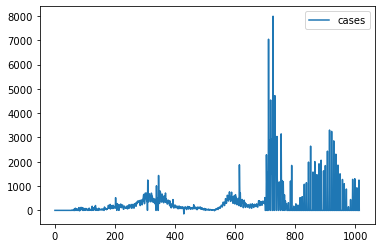

In [92]:
#plotting a basic time plot to understand the data distribution
jefferson_cases_by_date.plot()
plt.show()

# Step 1: Analysis

Applying the PELT test to identify change points in the data (using ruptures package)

In [101]:
import ruptures as rpt

In [111]:
# For Merging mask mandate data and the confirmed cases data on field= date
masks_df = jefferson_mask_mandates_april_2020_aug_2021[['date','Face_Masks_Required_in_Public']]

In [112]:
type(masks_df)

pandas.core.frame.DataFrame

In [114]:
jefferson_cases_by_date['date'] = pd.to_datetime(jefferson_cases_by_date['date'])
masks_df['date']=pd.to_datetime(masks_df['date'])

<ipython-input-114-3f3ea95294b1>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [115]:
jefferson_cases_by_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1014 non-null   datetime64[ns]
 1   cases   1014 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 16.0 KB


In [116]:
masks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 493 entries, 278768 to 1098101
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           493 non-null    datetime64[ns]
 1   Face_Masks_Required_in_Public  493 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 11.6+ KB


In [117]:
masks_df.nunique()

date                             493
Face_Masks_Required_in_Public      2
dtype: int64

In [118]:
jefferson_cases_by_date.nunique()

date     1014
cases     431
dtype: int64

In [119]:
#perform merging 
merged_df=pd.merge(jefferson_cases_by_date,masks_df, how='left')

In [120]:
#viewing merged data set
merged_df

,date,cases,Face_Masks_Required_in_Public
0,2020-01-23,0.0,NaN
1,2020-01-24,0.0,NaN
2,2020-01-25,0.0,NaN
3,2020-01-26,0.0,NaN
4,2020-01-27,0.0,NaN
...,...,...,...
1009,2022-10-28,0.0,NaN
1010,2022-10-29,0.0,NaN
1011,2022-10-30,0.0,NaN
1012,2022-10-31,1248.0,NaN


In [121]:
# replacing null value with 'No'
merged_df["Face_Masks_Required_in_Public"] = merged_df["Face_Masks_Required_in_Public"].fillna("No")

In [122]:
merged_df

,date,cases,Face_Masks_Required_in_Public
0,2020-01-23,0.0,No
1,2020-01-24,0.0,No
2,2020-01-25,0.0,No
3,2020-01-26,0.0,No
4,2020-01-27,0.0,No
...,...,...,...
1009,2022-10-28,0.0,No
1010,2022-10-29,0.0,No
1011,2022-10-30,0.0,No
1012,2022-10-31,1248.0,No


In [123]:
#splitting the merged df into 2 sub dfs - one where mask mandate is enforced, another wheere its not enforced

mask= merged_df[merged_df["Face_Masks_Required_in_Public"]=="Yes"]
no_mask= merged_df[merged_df["Face_Masks_Required_in_Public"]=="No"]

In [124]:
#performing modelling tasks on the main merged dataset to obtain the changepoints

cases = np.array(merged_df["cases"])
algo2 = rpt.Pelt(model="rbf").fit(cases)

change_locations2= algo2.predict(pen=10)
change_locations2 = merged_df.iloc[change_locations2[:-1]].index.to_list()


In [125]:
#viewing the obtained changepoints
change_locations2

[175, 270, 395, 560, 610, 700, 770]

# Step 2: Visualize

In [105]:
#performing moving average over 7 days to to account for case counts not being updated for every single day in a week to help smooth out-trend information by creating a constantly updated average value in the plot.

rolled_df=merged_df
rolled_df['cases']=rolled_df['cases'].rolling(7).mean()
rolled_df['cases'].fillna(0)

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
1009    132.571429
1010    132.571429
1011    132.571429
1012    178.285714
1013    178.285714
Name: cases, Length: 1014, dtype: float64

In [129]:
#removing any NaN values in the 2 sub-categorical dfs created from the merged_df to plot accurately( since matplotlib generalized NaN discontinuation in dates to 0 values in plots)

mask = mask.set_index('date')
mask = mask.resample('D').first()
mask = mask.reset_index()


no_mask = no_mask.set_index('date')
no_mask = no_mask.resample('D').first()
no_mask = no_mask.reset_index()

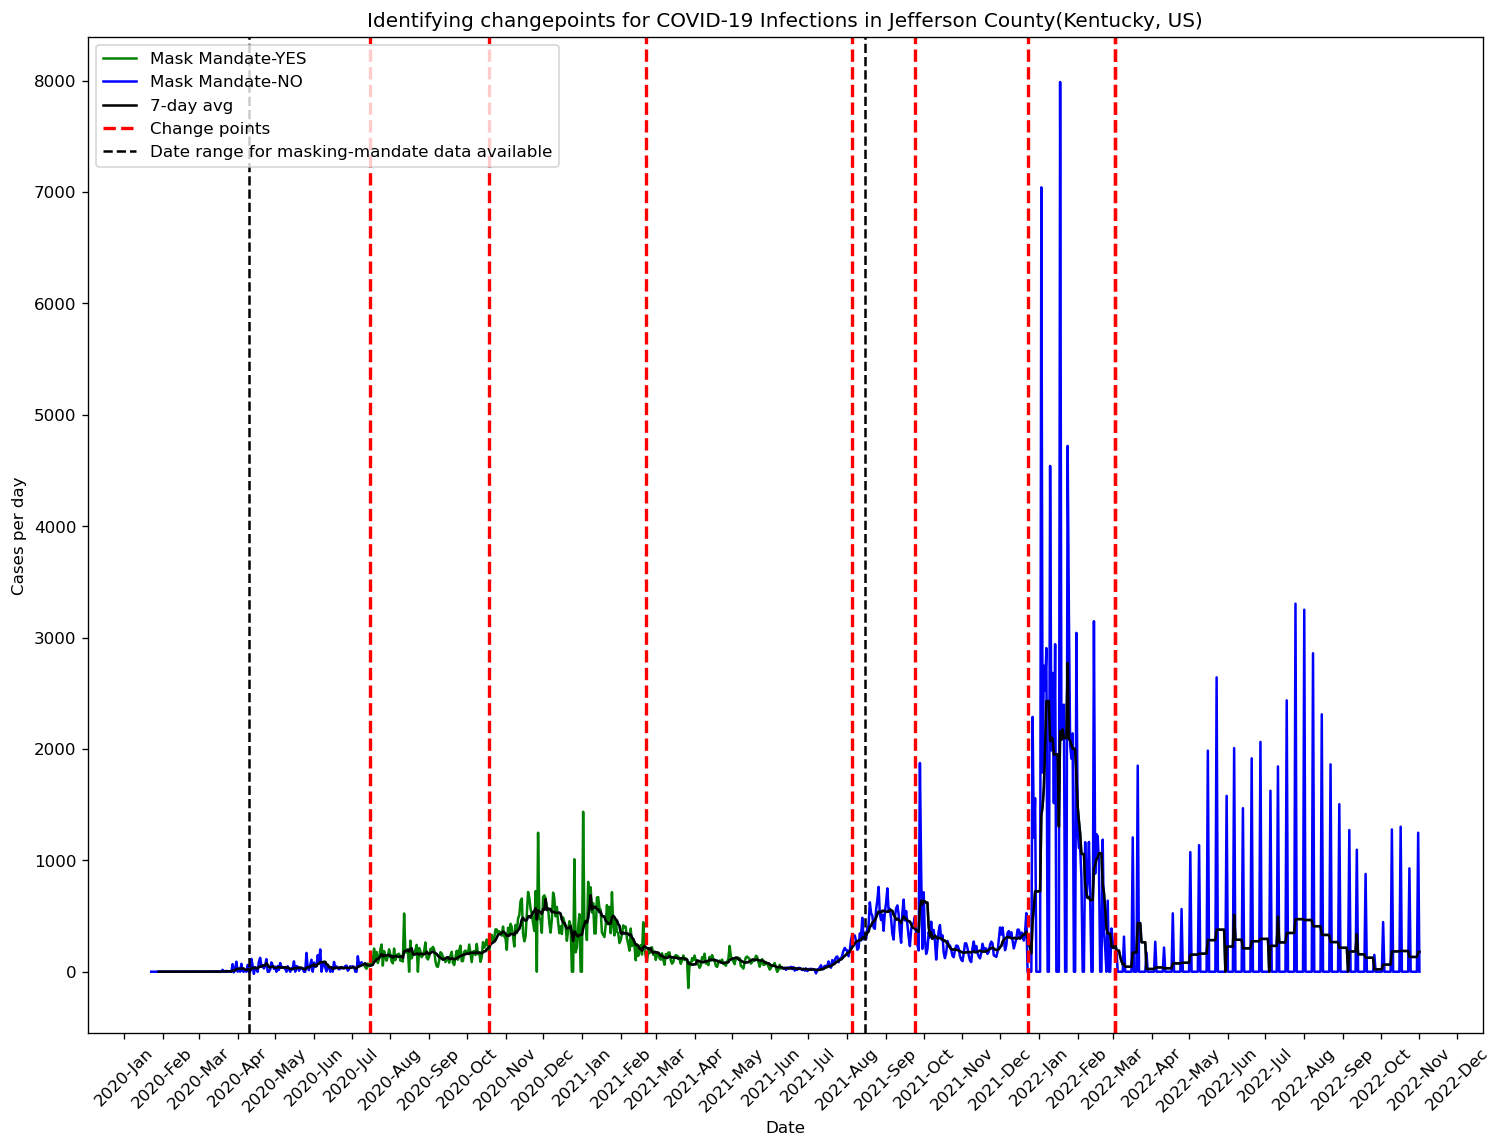

In [142]:
#for plotting the final visualization


from matplotlib.pyplot import figure
figure(figsize=(15, 11), dpi=120) #defining plot size

merged_df['date'] = pd.to_datetime(merged_df['date'])
plt.plot(merged_df['date'],merged_df['cases']) 


# define the date formatting in the X-axis
dtFmt = mdates.DateFormatter('%Y-%b') 
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

#plotting the section of line corresponding mask mandate enforced region in green
plt.plot(mask['date'],mask['cases'],'green', label="Mask Mandate-YES")

#plotting the section of line corresponding no mask mandate enforced region in blue
plt.plot(no_mask['date'],no_mask['cases'],'blue', label="Mask Mandate-NO")

#plotting the 7-day avg.case line plot
plt.plot(rolled_df['date'],rolled_df['cases'],'black', label="7-day avg")

#including the changepoints into the visualization
for i in merged_df.loc[merged_df['date'].isin(red_dates),'date'].to_numpy():
    plt.axvline(i,lw=2,linestyle='--', color='red')
plt.axvline(i,lw=2, color='red', linestyle='--',label='Change points')

#plotting the date range for when masking madate data is available
plt.axvline(pd.Timestamp('2020-04-10'),linestyle='--', color='black', label='Date range for masking-mandate data available')
plt.axvline(pd.Timestamp('2021-08-15'),linestyle='--', color='black')

plt.title('Identifying changepoints for COVID-19 Infections in Jefferson County(Kentucky, US)')
plt.xlabel('Date')
plt.ylabel('Cases per day')
plt.xticks(rotation=45)
plt.legend(loc='best')


# ( Optional:  for daily infection rate)

In [143]:
new=merged_df

#obtaining the change in the case count per day (ie., infection rate)
new['cases']=new['cases'] - new.shift(periods=1)['cases']

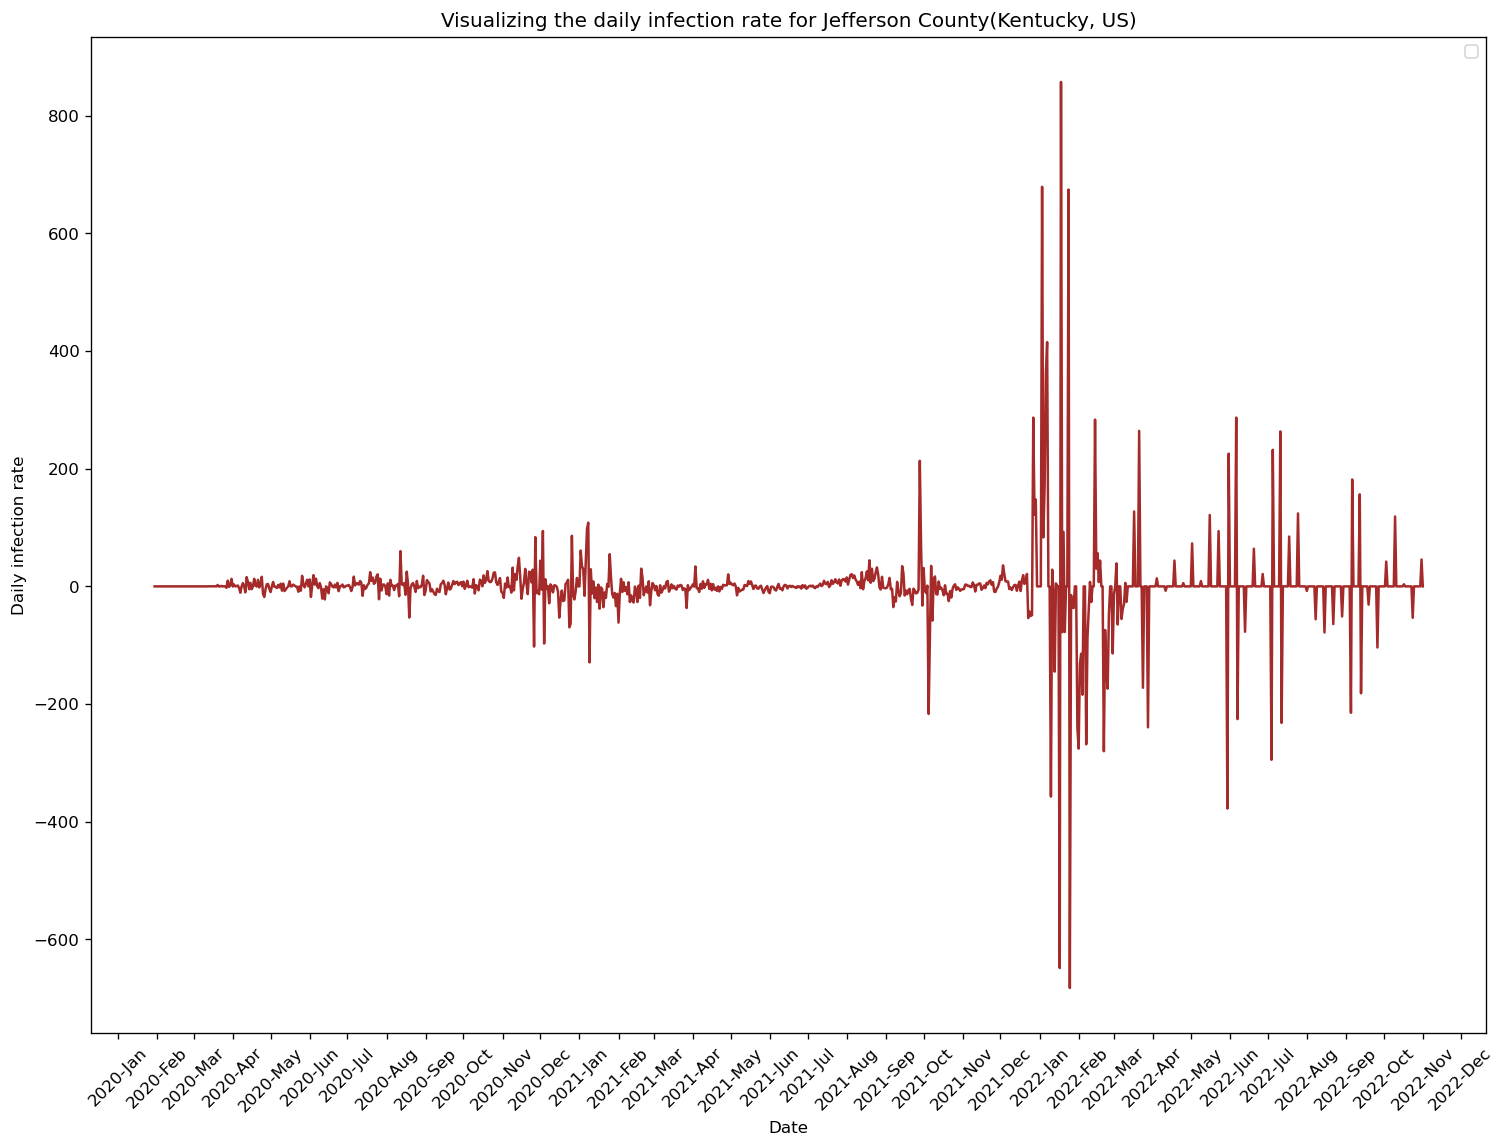

In [145]:
#plotting the daily infection rate

from matplotlib.pyplot import figure
figure(figsize=(15, 11), dpi=120)

new['date'] = pd.to_datetime(new['date'])
plt.plot(new['date'],new['cases'],'brown') 


dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.title('Visualizing the daily infection rate for Jefferson County(Kentucky, US)')
plt.xlabel('Date')
plt.ylabel('Daily infection rate')
plt.xticks(rotation=45)
plt.legend(loc='best')